In [1]:
%pylab inline
import pymc3 as pm
from scipy import stats
from theano import tensor as tt

Populating the interactive namespace from numpy and matplotlib


In [2]:
Nd = 5
N = 100
mu0 = stats.norm.rvs(loc=0, scale=1., size=Nd)
W = stats.norm.rvs(loc=0, scale=1, size=(Nd, Nd))
K = W*W.transpose() + np.diagflat(np.ones((Nd, 1))*Nd)
L = np.linalg.cholesky(K)
X = stats.multivariate_normal.rvs(mu0, K, size=N)

In [3]:
X_ma = ma.array(X)
X_ma[:2, [0, 1, 4]] = ma.masked
X_ma[2:6, [2, 3]] = ma.masked

# X_ma

In [4]:
X_nonma = X_ma.data[X_ma.mask.sum(axis=1) == 0]
maskall = X_ma.mask[X_ma.mask.sum(axis=1) > 0]
X_slice = X_ma.data[X_ma.mask.sum(axis=1) > 0]
uni_case = np.unique(maskall, axis=0)

In [5]:
maskall

array([[ True,  True, False, False,  True],
       [ True,  True, False, False,  True],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False],
       [False, False,  True,  True, False]])

In [6]:
for im in uni_case:
    pass
im

array([ True,  True, False, False,  True])

In [7]:
X_slice[np.sum(maskall == im, axis=1) > 0, :][:, im == False]

array([[ 1.00431088, -0.86473926],
       [ 3.00912129, -3.26441491]])

In [8]:
K[im == False, :][:, im == False]

array([[ 5.02721206, -1.04437931],
       [-1.04437931,  5.03497863]])

## Full data set (as comparison)

In [9]:
with pm.Model() as model0:
    mu = pm.Normal('mu', mu=0, sd=10, shape=Nd)
    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    packed_chol = pm.LKJCholeskyCov('chol_cov', n=Nd, eta=1, sd_dist=sd_dist)
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(Nd, packed_chol, lower=True)
    cov = pm.Deterministic('cov', tt.dot(chol, chol.T))
    
    obs = pm.MvNormal('obs', mu=mu, chol=chol, observed=X)
    trace0 = pm.sample(2000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, mu]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:16<00:00, 621.93draws/s]


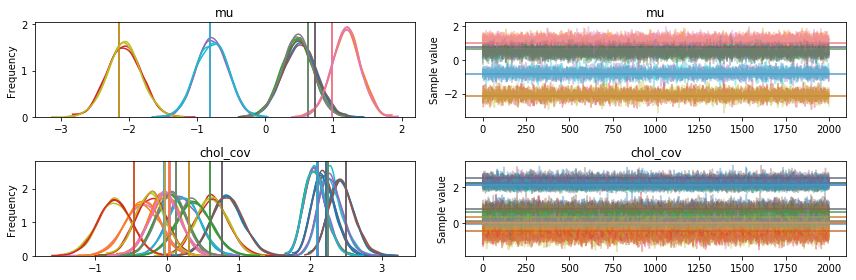

In [14]:
pm.traceplot(trace0, varnames=['mu', 'chol_cov'],  lines=dict(mu=mu0, chol_cov=L[L!=0]));

## nonmasked data set only

In [15]:
with pm.Model() as model0_:
    mu = pm.Normal('mu', mu=0, sd=10, shape=Nd)
    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    packed_chol = pm.LKJCholeskyCov('chol_cov', n=Nd, eta=1, sd_dist=sd_dist)
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(Nd, packed_chol, lower=True)
    cov = pm.Deterministic('cov', tt.dot(chol, chol.T))
    
    obs = pm.MvNormal('obs', mu=mu, chol=chol, observed=X_nonma)
    trace0_ = pm.sample(2000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, mu]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:18<00:00, 550.28draws/s]


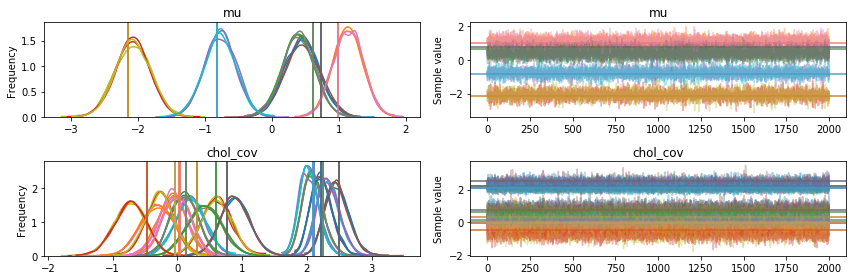

In [16]:
pm.traceplot(trace0_, varnames=['mu', 'chol_cov'],  lines=dict(mu=mu0, chol_cov=L[L!=0]));

## with masked data

In [18]:
## Full data set (as comparison)

with pm.Model() as model0:
    mu = pm.Normal('mu', mu=0, sd=10, shape=Nd)
    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    packed_chol = pm.LKJCholeskyCov('chol_cov', n=Nd, eta=1, sd_dist=sd_dist)
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(Nd, packed_chol, lower=True)
    cov = pm.Deterministic('cov', tt.dot(chol, chol.T))
    # non-masked data (no missing observation)
    obs = pm.MvNormal('obs', mu=mu, chol=chol, observed=X_nonma)
    # masked data. It is likely that we can optimized it further by turning it into a potential
    # (thus removing the for-loop)
    for i, im in enumerate(uni_case):
        pm.MvNormal('obs%i'%(i), 
                    mu[im == False],
                    cov[im == False, :][:, im == False],
                    observed=X_slice[np.sum(maskall == im, axis=1) > 0, :][:, im == False])
    trace1 = pm.sample(2000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, mu]
Sampling 4 chains: 100%|██████████| 10000/10000 [01:06<00:00, 149.89draws/s]


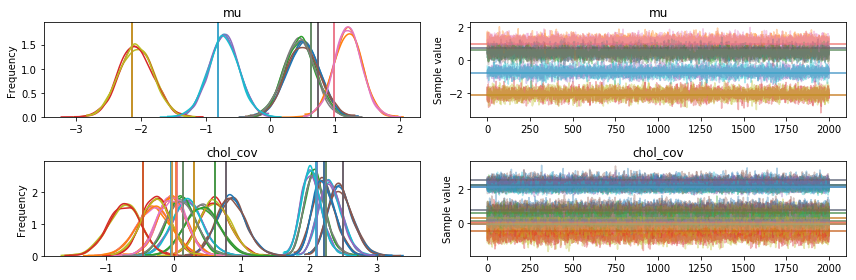

In [19]:
pm.traceplot(trace1, varnames=['mu', 'chol_cov'],  lines=dict(mu=mu0, chol_cov=L[L!=0]));

## contruct conditional and sample from it

In [39]:
def MVN_conditional(mu_post, cov_post, conditional, size=None):
    mask = conditional.mask
    mu1 = mu_post[mask == True]
    mu2 = mu_post[mask == False]
    a = conditional.data[mask == False]
    S11 = cov_post[mask == True, :][:, mask == True]
    S12 = cov_post[mask == True, :][:, mask == False]
    S21 = S12.T
    S22 = cov_post[mask == False, :][:, mask == False]
    mu_new = mu1 + (S12.dot(np.linalg.inv(S22))).dot(a-mu2)
    S_new = S11 - (S12.dot(np.linalg.inv(S22))).dot(S21)
    return stats.multivariate_normal.rvs(mu_new, S_new, size=size)

conditional = ma.array([0, 0, .5, .6, 0], mask=[1, 1, 0, 0, 1])
mu_post = trace1[0]['mu']
cov_post = trace1[0]['cov']
MVN_conditional(mu_post, cov_post, conditional, size=10)

array([[ 2.10303316,  2.80298803, -1.24667316],
       [ 3.55703786,  1.09674717, -0.93247058],
       [ 0.21154469,  1.97380088, -1.54638871],
       [-0.21937215, -1.018331  , -4.0542664 ],
       [-2.91092503,  1.69366756,  1.50827649],
       [ 0.48719525,  0.03570973, -3.63183117],
       [-1.61070323,  0.93840086, -3.20541475],
       [-2.90829208,  5.55702223,  0.3346094 ],
       [-2.56168139,  0.68126697, -4.09009314],
       [-3.52952689,  3.65461607, -0.11125448]])

In [43]:
X0_post_condi = []
for ic in range(trace1.nchains):
    trace = trace1._straces[ic]
    temp = []
    for point in trace:
        mu_post = point['mu']
        cov_post = point['cov']
        temp.append(MVN_conditional(mu_post, cov_post, conditional)[0])
    X0_post_condi.append(np.asarray(temp))
X0_post_condi = np.asarray(X0_post_condi)

In [45]:
X0_post_condi.shape

(4, 2000)

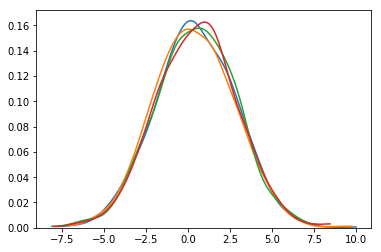

In [50]:
_, ax = plt.subplots(1, 1)
for i in X0_post_condi:
    pm.kdeplot(i, ax=ax);